# Only the mathematical trading strategy for getting the signals

In [19]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## Dataset

In [20]:
df_3m = pd.read_csv('datasets/btc_5m.csv')
df_3m['datetime'] = pd.to_datetime(df_3m['datetime'])
df_3m.set_index('datetime', inplace=True)
df_3m

,open,high,low,close,volume
datetime,,,,,
2018-01-01 05:30:00,13715.65,13715.65,13576.28,13600.00,33.617798
2018-01-01 05:35:00,13600.00,13600.00,13501.01,13554.58,40.528679
2018-01-01 05:40:00,13554.58,13569.97,13400.01,13556.15,49.469536
2018-01-01 05:45:00,13533.75,13547.73,13402.00,13430.52,32.725614
2018-01-01 05:50:00,13440.01,13459.99,13410.44,13439.94,26.614135
...,...,...,...,...,...
2022-01-31 05:10:00,37950.55,37979.31,37875.58,37959.87,119.164080
2022-01-31 05:15:00,37959.87,37959.88,37876.94,37896.41,73.051970
2022-01-31 05:20:00,37896.41,37948.79,37870.00,37928.03,41.395230


In [21]:
def filter_df(df, start_date, end_date):
    subset_df = df.loc[start_date:end_date]
    return subset_df

start_date = '2019-01-01'
end_date = '2019-02-01'
filtetred_df_3m = filter_df(df_3m, start_date, end_date)
print(filtetred_df_3m.shape)
filtetred_df_3m.iloc[[0,-1],:]

(9216, 5)


,open,high,low,close,volume
datetime,,,,,
2019-01-01 00:00:00,3740.38,3746.44,3740.10,3745.97,49.895137
2019-02-01 23:55:00,3462.69,3464.39,3461.36,3463.00,42.819057


In [22]:
def plot_candlestick_chart(df,num_candles=-1):
    if num_candles != -1:
        df = df.iloc[:num_candles]
    
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

    # Customize the layout
    fig.update_layout(title='Candlestick chart',
                    xaxis_title='Date and Time',
                    yaxis_title='Price data',
                    xaxis_rangeslider_visible=False)

    # Show the plot
    fig.show()

In [23]:
# plot_candlestick_chart(df_3m,num_candles=500)

## Strategy

### Adding the indicators

In [24]:
def add_indicators(df):
    # SMA
    df['SMA_14'] = df['close'].rolling(window=14).mean()
    df['SMA_20'] = df['close'].rolling(window=20).mean()
    df['SMA_50'] = df['close'].rolling(window=50).mean()
    
    # RSI
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Moving Average Convergence Divergence (MACD)
    short_window = 12
    long_window = 26
    signal_window = 9

    exp_short = df['close'].ewm(span=short_window, adjust=False).mean()
    exp_long = df['close'].ewm(span=long_window, adjust=False).mean()

    df['MACD'] = exp_short - exp_long
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

    # Bollinger Bands
    window = 20
    df['Upper_Band'] = df['SMA_20'] + 2 * df['close'].rolling(window=window).std()
    df['Lower_Band'] = df['SMA_20'] - 2 * df['close'].rolling(window=window).std()

    # ATR
    # Calculate True Range (TR)
    df['High-Low'] = df['high'] - df['low']
    df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
    df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))

    df['TrueRange'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)

    # Choose the ATR period (e.g., 14 days)
    atr_period = 14

    # Calculate ATR using rolling mean
    df['ATR'] = df['TrueRange'].rolling(window=atr_period).mean()

    # Drop intermediate columns used for calculation
    df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose', 'TrueRange'], axis=1, inplace=True)

    # Removing null rows
    df = df.dropna()
    return df

In [25]:
test_df = add_indicators(filtetred_df_3m)
print(test_df.shape)
test_df

(9167, 14)


C:\Users\sanya\AppData\Local\Temp\ipykernel_19552\3146903090.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA_14'] = df['close'].rolling(window=14).mean()
C:\Users\sanya\AppData\Local\Temp\ipykernel_19552\3146903090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA_20'] = df['close'].rolling(window=20).mean()
C:\Users\sanya\AppData\Local\Temp\ipykernel_19552\3146903090.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,open,high,low,close,volume,SMA_14,SMA_20,SMA_50,RSI,MACD,Signal_Line,Upper_Band,Lower_Band,ATR
datetime,,,,,,,,,,,,,,
2019-01-01 04:05:00,3675.11,3677.00,3673.77,3676.83,38.109317,3670.260000,3671.5375,3691.5136,54.484733,-4.359932,-6.717307,3678.811708,3664.263292,6.090000
2019-01-01 04:10:00,3675.58,3684.40,3675.58,3682.29,66.335947,3671.031429,3671.9010,3690.2400,61.790393,-3.208085,-6.015463,3680.511737,3663.290263,6.310000
2019-01-01 04:15:00,3684.09,3685.00,3678.83,3679.08,76.793021,3671.628571,3672.0550,3688.8680,58.665008,-2.525151,-5.317400,3681.074858,3663.035142,6.288571
2019-01-01 04:20:00,3678.98,3684.00,3677.45,3682.12,54.453393,3672.612857,3672.4995,3687.5970,64.089980,-1.718804,-4.597681,3682.577320,3662.421680,6.325000
2019-01-01 04:25:00,3682.09,3687.02,3680.82,3686.43,59.439047,3674.120714,3673.0825,3686.5172,71.030086,-0.723646,-3.822874,3684.910456,3661.254544,6.477857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-01 23:35:00,3461.19,3461.66,3459.52,3461.00,65.856739,3461.555000,3459.2510,3461.3168,55.911567,0.275523,0.157228,3467.693958,3450.808042,4.285000
2019-02-01 23:40:00,3461.00,3461.65,3458.05,3459.78,38.242410,3461.585714,3459.5350,3461.0724,50.707470,0.195278,0.164838,3467.623077,3451.446923,4.332143
2019-02-01 23:45:00,3459.85,3462.00,3458.05,3460.43,72.197611,3461.473571,3459.8145,3460.8250,47.234942,0.182034,0.168277,3467.600132,3452.028868,4.343571


<Figure size 1400x600 with 0 Axes>

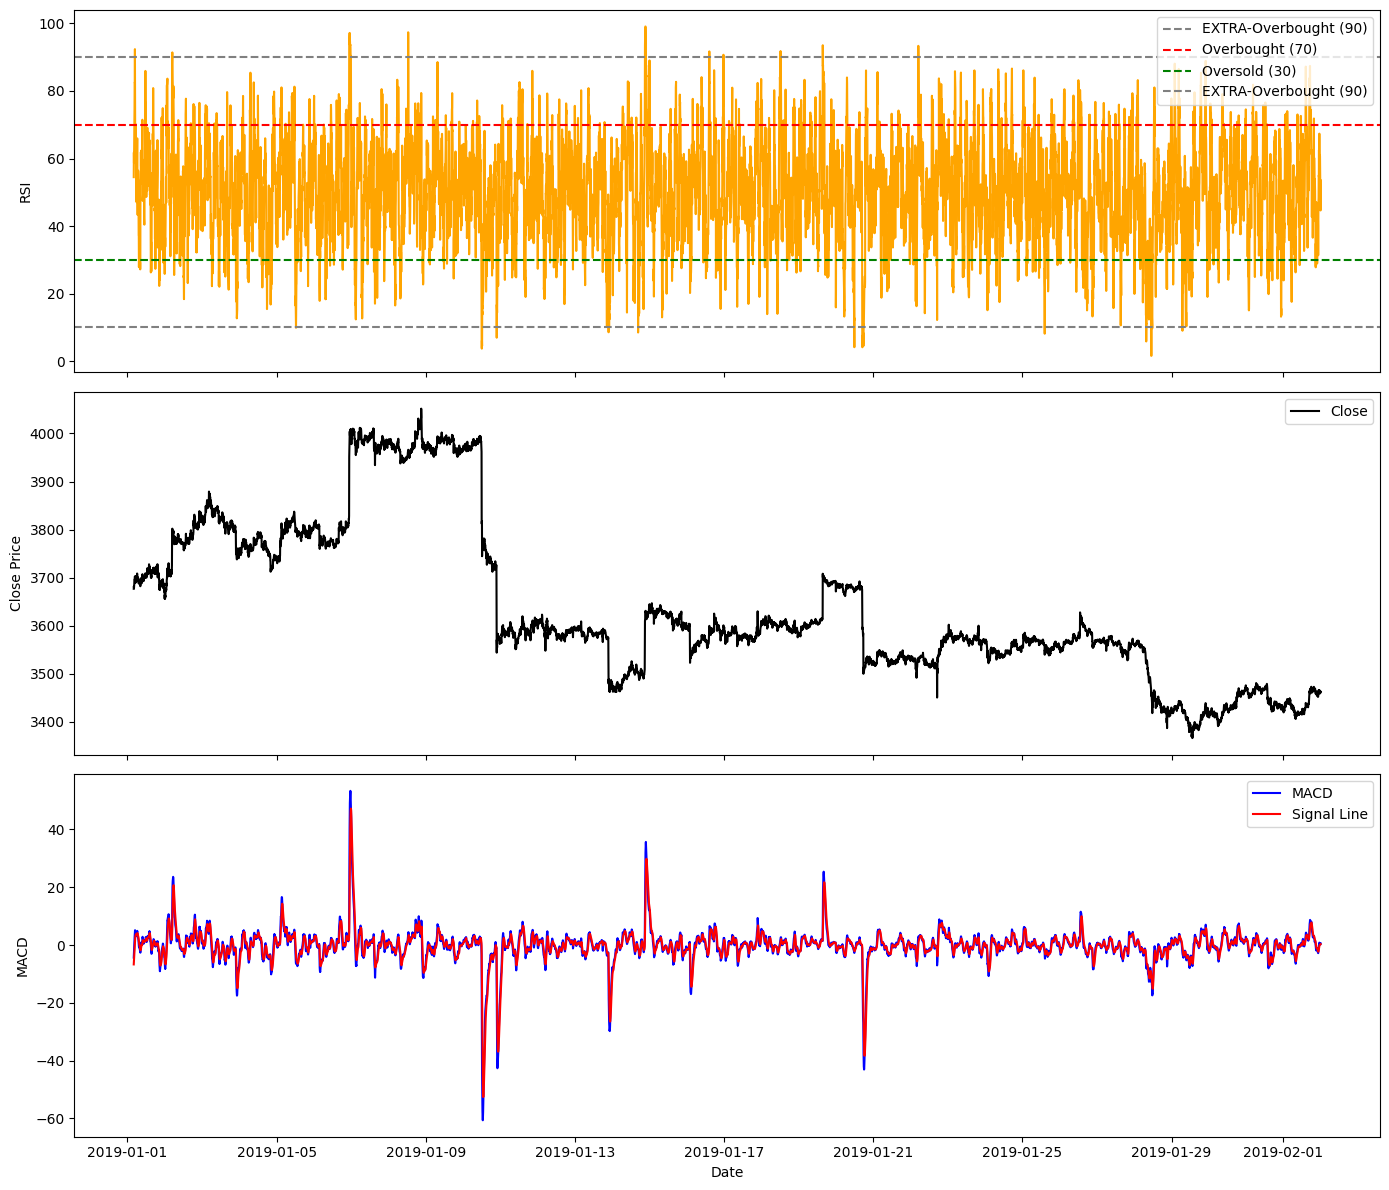

In [26]:
# For understanding the indicators

plot_df = test_df.iloc[:,:]
plt.figure(figsize=(14, 6))

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), sharex=True)

# Plotting RSI
axes[0].plot(plot_df.index, plot_df['RSI'], color='orange')
axes[0].axhline(90, color='grey', linestyle='--', label='EXTRA-Overbought (90)')
axes[0].axhline(70, color='r', linestyle='--', label='Overbought (70)')
axes[0].axhline(30, color='g', linestyle='--', label='Oversold (30)')
axes[0].axhline(10, color='grey', linestyle='--', label='EXTRA-Overbought (90)')
axes[0].legend()
axes[0].set_ylabel('RSI')

# Plotting Close values and SMAs
axes[1].plot(plot_df.index, plot_df['close'], label='Close', color='black')
# axes[1].plot(plot_df['SMA_14'],label="14 previous average")
# axes[1].plot(plot_df['SMA_20'],label="20 previous average")
axes[1].legend()
axes[1].set_ylabel('Close Price')

# Plotting MACD and Signal Line
axes[2].plot(plot_df.index, plot_df['MACD'], label='MACD', color='blue')
axes[2].plot(plot_df.index, plot_df['Signal_Line'], label='Signal Line', color='red')
axes[2].legend()
axes[2].set_ylabel('MACD')
axes[2].set_xlabel('Date')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# plot_candlestick_chart(plot_df)

In [27]:
# States
usd = 10000
btc = 0

# Define trading parameters
atr_factor = 1.5
take_profit_factor = 2
stop_loss = 0
target = 0
initial_close = test_df.loc[test_df.index[0],'close']
prev_resistance, resistance = initial_close,initial_close
prev_support, support = initial_close,initial_close

# Initialize columns for signals and balances
test_df.loc[:,'Signal'] = ''
test_df.loc[:,'Balance_USD'] = None
test_df.loc[:,'Balance_BTC'] = None

C:\Users\sanya\AppData\Local\Temp\ipykernel_19552\639996591.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:,'Signal'] = ''
C:\Users\sanya\AppData\Local\Temp\ipykernel_19552\639996591.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:,'Balance_USD'] = None
C:\Users\sanya\AppData\Local\Temp\ipykernel_19552\639996591.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [28]:
# Signals
def buy(usd, btc, current_close):
    if usd > 0 and btc == 0:
        btc = (usd) / current_close
        usd = 0
        return usd, btc, 'Buy'
    else:
        return usd, btc, "Holding"

def sell(usd, btc, current_close):
    if btc > 0 and usd == 0:
        usd = (btc) * current_close
        btc = 0
        return usd, btc, 'Sell'
    else:
        return usd, btc, 'Waiting'

In [29]:
# Dataframe updation
def update_df(i,usd, btc, signal):
    test_df.at[test_df.index[i], 'Signal'] = signal
    test_df.at[test_df.index[i], 'Balance_USD'] = usd
    test_df.at[test_df.index[i], 'Balance_BTC'] = btc

In [30]:
from keras.models import load_model
model = load_model("models/BTC_LSTM_cp_1704897479.313657.h5")

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_test_df = scaler.fit_transform(np.array(test_df['close']).reshape(-1,1))

In [32]:
np.array(test_df['close'][1:16])

array([3682.29, 3679.08, 3682.12, 3686.43, 3695.28, 3696.1 , 3695.85,
       3697.53, 3702.72, 3698.09, 3689.94, 3693.92, 3689.12, 3691.7 ,
       3691.64])

In [33]:
original_array = scaled_test_df[1:15]
reshaped_array = original_array.reshape((1, original_array.shape[0], 1))
reshaped_array.shape
# predicted = model.predict(reshaped_array)
# scaler.inverse_transform(predicted)

(1, 14, 1)

In [34]:
# Trading loop
for i in range(14, len(test_df)):
    print(i)
    signal = ''
    current_row = test_df.iloc[i]
    previous_closes = scaled_test_df[i-14:i]
    scaled_previous_closes = previous_closes.reshape((1, previous_closes.shape[0], 1))
    predicted = model.predict(scaled_previous_closes,verbose=0)
    next_close = scaler.inverse_transform(predicted)
    if next_close < stop_loss:
        usd, btc, signal = sell(usd, btc, current_row['close'])
        update_df(i, usd, btc, signal)
        continue

    
    indications = {
        "MACD-signal_line":0,
        # "RSI":0,
        # "candlestick":0,
    }

    # Check for general trend of the trade
    if current_row['MACD'] > current_row['Signal_Line']:
        indications['MACD-signal_line'] = 1 # Positive indication
    elif current_row['MACD'] < current_row['Signal_Line']:
        indications['MACD-signal_line'] = -1 # Negative indication
        # print(f"{i} MACD:{current_row['MACD']}\tSignal_Line:{current_row['Signal_Line']}")
    else:
        indications['MACD-signal_line'] = 0 # Neutral indication

    # Decide the signal
    vote = max(set(indications.values()), key=list(indications.values()).count)
    if vote == 1: # If enough things indicate upwards, if have sell, buy
        usd, btc, signal = buy(usd, btc, current_row['close'])
        stop_loss = current_row['close'] * (0.9785) # 1 - 0.02 - 0.0015
        update_df(i, usd, btc, signal)
        continue
    if vote == -1:# If enough things indicate downwards, and own btc, sell
        usd, btc, signal = sell(usd, btc, current_row['close'])
        update_df(i, usd, btc, signal)
        continue
    else: # Else just wait for the next turn
        signal = "Wait" if usd > 0  else "Hold"
        update_df(i, usd, btc, signal)
        continue
    # print(f"{vote}\t{signal}")
    # Update the progress
    # update_df(i, usd, btc, signal, indications)

test_df

14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
28

,open,high,low,close,volume,SMA_14,SMA_20,SMA_50,RSI,MACD,Signal_Line,Upper_Band,Lower_Band,ATR,Signal,Balance_USD,Balance_BTC
datetime,,,,,,,,,,,,,,,,,
2019-01-01 04:05:00,3675.11,3677.00,3673.77,3676.83,38.109317,3670.260000,3671.5375,3691.5136,54.484733,-4.359932,-6.717307,3678.811708,3664.263292,6.090000,,None,None
2019-01-01 04:10:00,3675.58,3684.40,3675.58,3682.29,66.335947,3671.031429,3671.9010,3690.2400,61.790393,-3.208085,-6.015463,3680.511737,3663.290263,6.310000,,None,None
2019-01-01 04:15:00,3684.09,3685.00,3678.83,3679.08,76.793021,3671.628571,3672.0550,3688.8680,58.665008,-2.525151,-5.317400,3681.074858,3663.035142,6.288571,,None,None
2019-01-01 04:20:00,3678.98,3684.00,3677.45,3682.12,54.453393,3672.612857,3672.4995,3687.5970,64.089980,-1.718804,-4.597681,3682.577320,3662.421680,6.325000,,None,None
2019-01-01 04:25:00,3682.09,3687.02,3680.82,3686.43,59.439047,3674.120714,3673.0825,3686.5172,71.030086,-0.723646,-3.822874,3684.910456,3661.254544,6.477857,,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-01 23:35:00,3461.19,3461.66,3459.52,3461.00,65.856739,3461.555000,3459.2510,3461.3168,55.911567,0.275523,0.157228,3467.693958,3450.808042,4.285000,Waiting,9691.187431,0
2019-02-01 23:40:00,3461.00,3461.65,3458.05,3459.78,38.242410,3461.585714,3459.5350,3461.0724,50.707470,0.195278,0.164838,3467.623077,3451.446923,4.332143,Waiting,9691.187431,0
2019-02-01 23:45:00,3459.85,3462.00,3458.05,3460.43,72.197611,3461.473571,3459.8145,3460.8250,47.234942,0.182034,0.168277,3467.600132,3452.028868,4.343571,Waiting,9691.187431,0


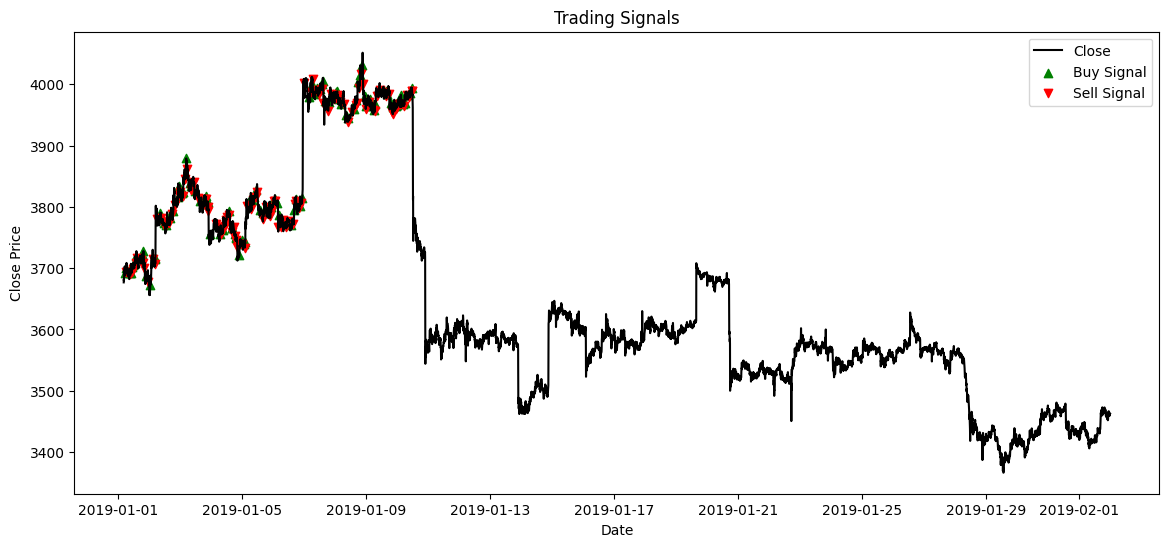

In [36]:
plot_df = test_df.iloc[:,:]
plt.figure(figsize=(14, 6))

# Plot close values
plt.plot(plot_df.index, plot_df['close'], label='Close', color='black')
# plt.plot(plot_df['SMA_14'],label="14 previous average")
# plt.plot(plot_df['SMA_20'],label="20 previous average")
# plt.plot(plot_df['SMA_50'],label="50 previous average")


# Marking Buy signals with green upward arrows
plt.scatter(plot_df[plot_df['Signal'] == 'Buy'].index, plot_df[plot_df['Signal'] == 'Buy']['close'], label='Buy Signal', marker='^', color='g', alpha=1)

# Marking Sell signals with red downward arrows
plt.scatter(plot_df[plot_df['Signal'] == 'Sell'].index, plot_df[plot_df['Signal'] == 'Sell']['close'], label='Sell Signal', marker='v', color='r', alpha=1)

# Marking Wait signals with blue circles
# plt.scatter(plot_df[plot_df['Signal'] == 'Wait'].index, plot_df[plot_df['Signal'] == 'Wait']['close'], label='Wait Signal', marker='o', color='b', alpha=0.5)

plt.title('Trading Signals')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# plot_candlestick_chart(plot_df)